In [1]:
%matplotlib inline
import xlrd
import operator
import math
import re
import nltk
import scipy
import random
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
from pactools.grid_search import GridSearchCVProgressBar
from collections import Counter, defaultdict
from itertools import chain, product
from decimal import Decimal
from ast import literal_eval
from tqdm import tqdm

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

pd.options.mode.chained_assignment = None

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
def importdata(file):
    df = pd.read_csv(file, index_col=0)
    df = df.loc[df['speech category'] == 'Main Speech']
    return df 
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.drop(columns=['tags'])
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


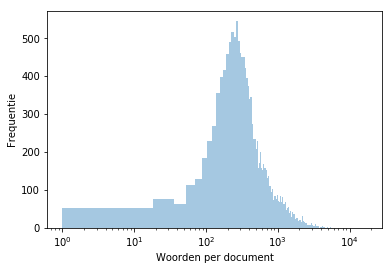

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
fit =scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
ax.set(xlabel='Woorden per document', ylabel='Frequentie')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


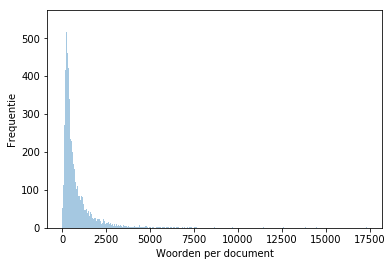

In [4]:
ax = sns.distplot(t, bins=1000, norm_hist=False,kde=False)
ax.set(xlabel='Woorden per document', ylabel='Frequentie')
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("Ondergrens:",math.exp(fit[0]+2*fit[1]),"\nBovengrens:",math.exp(fit[0]-2*fit[1]))
print("Mediaan",np.median([len(doc) for doc in list_text]),"\nGemiddelde",np.mean([len(doc) for doc in list_text]))
print("Overgebleven documenten:",len(df))

Ondergrens: 1492.675589876518 
Bovengrens: 27.339307082607387
Mediaan 386.0 
Gemiddelde 498.18961004094234
Overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string

# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


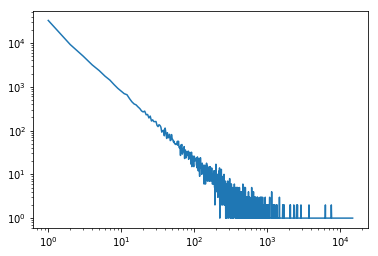

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
del list_text
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))
print("Accuracy:",accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax())))

              precision    recall  f1-score   support

      50PLUS       0.03      0.03      0.03       387
         CDA       0.13      0.13      0.13      1901
ChristenUnie       0.05      0.05      0.05      1068
         D66       0.11      0.11      0.11      1889
  GroenLinks       0.07      0.08      0.08      1068
         PVV       0.11      0.10      0.11      1700
        PvdA       0.12      0.12      0.12      1821
        PvdD       0.04      0.04      0.04       432
         SGP       0.04      0.04      0.04       655
          SP       0.15      0.15      0.15      2284
         VVD       0.12      0.13      0.13      1694

 avg / total       0.11      0.11      0.11     14899

Accuracy: 0.15329887911940399


# Models

In [10]:
def modelsdownload(file,only_doen=False):
    models_df = pd.read_excel(file, index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [11]:
models_df, models_dict = modelsdownload('Models.xlsx',True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}


In [12]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    print("Bezig: %s" %name)
    text = df.stemmed_text if text_dict[name] else df.normal_text
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name 
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_excel('Scores.xlsx', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_excel('Scores.xlsx')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [13]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [14]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
def classification_report_csv(real,predicted):
    report = classification_report(real, predicted)
    report_data = []
    lines = report.split('\n')
    for line in lines[0:-1]:
        row = {}
        row_data = line.split('     ')
        if len(row_data)<5:
            continue
        row['Partij'] = row_data[-5].replace(" ","")
        row['Precision'] = float(row_data[-4])
        row['Recall'] = float(row_data[-3])
        row['F1 score'] = float(row_data[-2])
        row['Documenten'] = int(row_data[-1])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df = df.reindex(["Partij","Precision","Recall",'F1 score',"Documenten"], axis=1).set_index('Partij')
    as_list = df.index.tolist()
    idx = as_list.index('avg/total')
    as_list[idx] = 'Totaal'
    df.index = as_list
    return df

In [15]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_excel(file, index_col=0).sort_values(['mean_test_f1_weighted'], ascending=False).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload('Models.xlsx',False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem

In [16]:
def traintest3(pipe, text, data, save=False):
    train, test = train_test_split(data, test_size=0.2)
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return [pipe, cnf_matrix, report, accuracy, indices]
    

def traintest(file, data, save=False, params=None, stemmed="stemmed_text",normal="normal_text"):
    n=5
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    text = stemmed if stem else normal
    pipelist, cnflist, reportlist, accuracylist, indiceslist = zip(*[traintest3(base_pipe, text, data, save=False) for x in tqdm(range(n))])
    accuracy = np.mean(accuracylist)
    cnf_matrix = np.mean(cnflist, axis=0)
    #https://stackoverflow.com/questions/45983321/sum-a-list-of-pandas-dataframes?rq=1
    report = reduce(lambda x, y: x.add(y, fill_value=0), reportlist) /n 
    report=report.round(2)
    report.Documenten = report.Documenten.round(0).astype(int)
    print(report)
    print(accuracy)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipelist[0], indiceslist

In [17]:
def mostimportantwords(pipe, countdf, filename=None):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = [[inv_vocab[t] for t in coefs[i].argsort()[-100:][::-1]] for i in range(coefs.shape[0])]
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    if filename!=None:
        with open("Verslag/Tables/%s1.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,:5].head(10).to_latex(index=False))
        with open("Verslag/Tables/%s2.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,5:].head(10).to_latex(index=False))
        top_words.to_excel("%s.xlsx" %filename)
        
    return top_words.head(10)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [20:46<00:00, 249.24s/it]


              Precision  Recall  F1 score  Documenten
50PLUS             0.96    0.87      0.91          74
CDA                0.82    0.81      0.81         368
ChristenUnie       0.90    0.78      0.83         235
D66                0.75    0.77      0.76         360
GroenLinks         0.91    0.73      0.81         216
PVV                0.82    0.90      0.86         344
PvdA               0.72    0.72      0.73         360
PvdD               0.89    0.85      0.87          83
SGP                0.85    0.85      0.85         134
SP                 0.75    0.86      0.80         459
VVD                0.77    0.74      0.75         345
Totaal             0.81    0.80      0.80        2980
0.8008053691275168


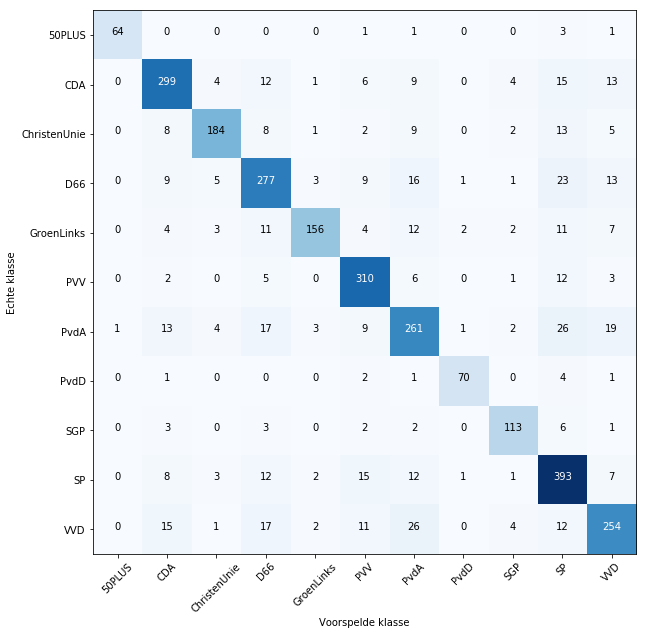

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlinks,pvv,de pvda,lid ouwehand,sgp,sp,de vvd
1,lid krol naar,het cda,christenunie,leden van veldhoven,lid van tongeren,de pvv,pvda,lid ouwehand naar,de sgp,de sp,vvd
2,lid krol,cda fractie,lid dik,mijn fractie,leden van tongeren,islamitische,de arbeid,het lid ouwehand,sgp fractie,sp fractie,de vvd fractie
3,het lid krol,de cda fractie,het lid dik,van veldhoven,tongeren,klever,van de arbeid,ouwehand,de sgp fractie,de sp fractie,vvd fractie
4,krol naar mij,de cda,lid dik faber,veldhoven,van tongeren,graaf,de partij van,ouwehand naar mij,leden dijkgraaf,lid van gerven,de vvd is
5,krol naar,lid omtzigt naar,leden voordewind,lid van veldhoven,lid voortman,miljard,partij van de,ouwehand naar,de leden dijkgraaf,gerven,vvd is
6,krol,lid omtzigt,de leden voordewind,lid van meenen,het lid voortman,nederland,partij van,dieren,leden van der,van gerven,voor de vvd
7,van 50plus,het lid omtzigt,dik faber,d66 is,lid voortman naar,graus,arbeid,voor de dieren,mevrouw de voorzitter,smaling,wat de vvd
8,gepensioneerden,omtzigt,faber,d66 wil,voortman,lid graus,pvda fractie,thieme,mevrouw de,gerven naar mij,de vvd wil
9,50plus is,geurts,dik,leden bergkamp,tongeren naar mij,het lid graus,de pvda fractie,de dieren,de leden bisschop,gerven naar,vvd vindt


In [18]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="confusionmatrix",params= {'SGD__max_iter':100})
mostimportantwords(pipe, countdf, filename='MostImportantWords')

# What went wrong

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


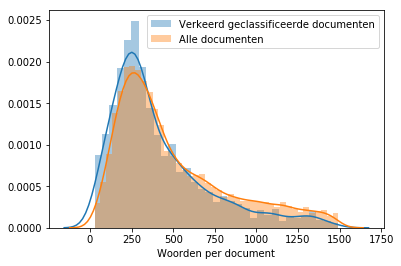

319.0


In [19]:
missclassdocs = df.loc[chain.from_iterable(indiceslist)]
np.mean([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
np.median([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
fig, ax = plt.subplots()
for a,l in [(missclassdocs.stemmed_text.apply(lambda x:len(x.split(" "))),'Verkeerd geclassificeerde documenten'), ((df.stemmed_text.apply(lambda x:len(x.split(" ")))),'Alle documenten')]:
    sns.distplot(a, kde=True, norm_hist=True, label=l, axlabel='Woorden per document')
plt.legend()
plt.savefig("Verslag/Tables/misclassifiedlengths.png")
plt.show()
print(np.median([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))]))

In [20]:
print(len(df[df['titel'].str.contains("Vragen van het lid")])/len(df))
print(len(missclassdocs[missclassdocs['titel'].str.contains("Vragen van het lid")])/len(missclassdocs))
print(np.median([len(doc) for doc in df[df['titel'].str.contains("Vragen van het lid")].stemmed_text.apply(lambda x: x.split(" "))]))


0.045640647023290154
0.08221024258760108
286.0


(-0.2971117709000704, 3.300783056235647e-05)

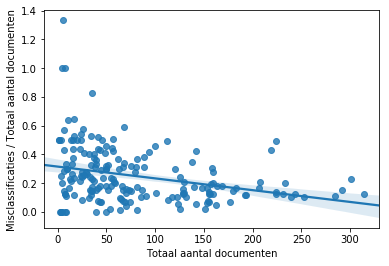

In [21]:
falsedocs = pd.concat([missclassdocs.groupby('surname').party.count(),df.groupby('surname').party.count(),missclassdocs.groupby('surname').party.count()/df.groupby('surname').party.count() ], axis=1)
falsedocs.to_excel('False.xlsx')
falsedocs.columns = ['a','b','c']
falsedocs.fillna(0,inplace=True)
ax = sns.regplot(x=falsedocs.b, y=falsedocs.c)
ax.set(xlabel = 'Totaal aantal documenten', ylabel = 'Misclassificaties / Totaal aantal documenten')
plt.savefig("Verslag/Tables/misclassifiedsprekers.png")
scipy.stats.pearsonr(falsedocs.b, falsedocs.c)

# Without Names

In [22]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
df['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
del temp

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [19:13<00:00, 230.74s/it]


              Precision  Recall  F1 score  Documenten
50PLUS             0.83    0.49      0.61          71
CDA                0.54    0.53      0.53         383
ChristenUnie       0.67    0.50      0.57         214
D66                0.55    0.55      0.55         372
GroenLinks         0.64    0.40      0.49         207
PVV                0.63    0.81      0.71         345
PvdA               0.51    0.48      0.50         359
PvdD               0.76    0.71      0.74          92
SGP                0.75    0.73      0.74         132
SP                 0.55    0.70      0.62         464
VVD                0.54    0.49      0.51         341
Totaal             0.59    0.58      0.58        2980
0.5834228187919462


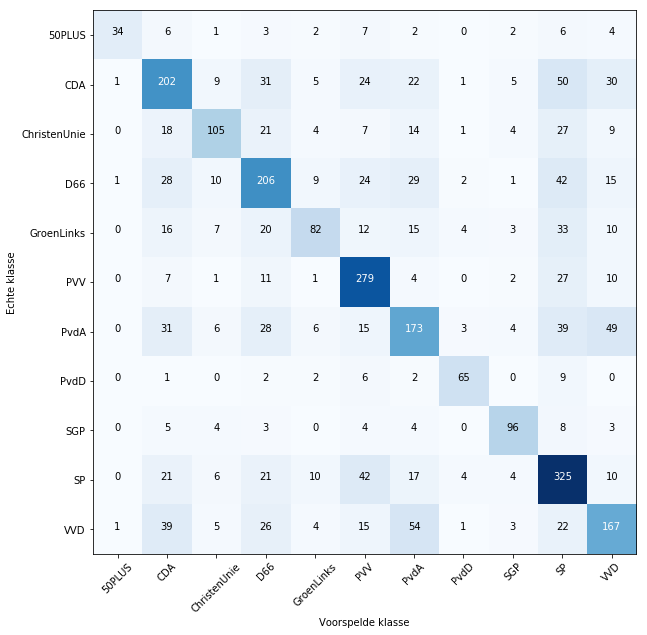

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerden,PARTIJ fractie,gezinnen,mijn fractie,zou,islamitische,en,dieren,mevrouw de voorzitter,zegt,PARTIJ
1,ouderen,inwoners,inderdaad,mijn,kamer hierover te,nederland,jongeren,milieu,mevrouw de,mening dat,volgens mij
2,oudere,regering,ik hoop,natuurlijk,schone energie,miljard,kinderen,dierenwelzijn,beantwoording,voorstellen,aruba
3,koopkrachtontwikkeling,PARTIJ,voedselverspilling,fractie,persoonsgebonden,natuurlijk,lagere overheden,natuur,punt,van mening dat,speelveld
4,plussers,hier,hoop,buitengewoon,schone,islam,goede,de bio,voor de beantwoording,bezuinigingen,aangegeven
5,werkenden,fractie,zullen,belangrijk,belastingontwijking,de islam,circulaire,bio,de beantwoording,de bevolking,volgens
6,overwegende dat,de regering,mensenhandel,het kabinet,in elk geval,al,tevens,industrie,wel,mensen,en
7,overwegende,echt,ik hoop dat,daarom,hierover te,asielzoekers,circulaire economie,bio industrie,allerlei,huurders,PARTIJ fractie
8,50 plussers,wij,rechtsstaat,minister,elk geval,verzorgingshuizen,mijn partij,klimaatverandering,bewindslieden,van mening,essentieel
9,voor gepensioneerden,de,horeca,vandaag,hierover te informeren,brussel,regering tevens,de bio industrie,nadrukkelijk,bevolking,regelgeving


In [23]:
pipe, indiceslist = traintest('Scores.xlsx', df, save="withoutnames",params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')
mostimportantwords(pipe, countdf, filename='MostImportantWordsWithoutNames')

# Only Names

In [24]:
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen = re.compile('|'.join(partijnamen))
df["names"] = df.text.apply(lambda x: re.findall(partijnamen, x)+re.findall(kamerlidnamen, x))
df["names"] = df.names.apply(lambda x: ' '.join([y.replace(" ", "") for y in x]).lower())
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text,stemmed_withoutnames,normal_withoutnames,names
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,vvd pvda vvd pvv rutte rutte rutte samsom rutte
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...,samsom rutte rutte samsom rutte samsom
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...,d66 pvda d66 d66 rutte samsom
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...,cda cda cda cda cda pechtold samsom wilders
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...,vvd pvda pvda vvd partijvandearbeid samsom samsom


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


              Precision  Recall  F1 score  Documenten
50PLUS             0.80    0.85      0.82          75
CDA                0.62    0.67      0.64         378
ChristenUnie       0.64    0.58      0.61         216
D66                0.62    0.50      0.56         379
GroenLinks         0.68    0.68      0.68         212
PVV                0.68    0.71      0.68         348
PvdA               0.51    0.54      0.51         367
PvdD               0.77    0.73      0.75          82
SGP                0.72    0.50      0.59         138
SP                 0.61    0.64      0.62         448
VVD                0.66    0.57      0.61         338
Totaal             0.64    0.61      0.62        2980
0.613758389261745


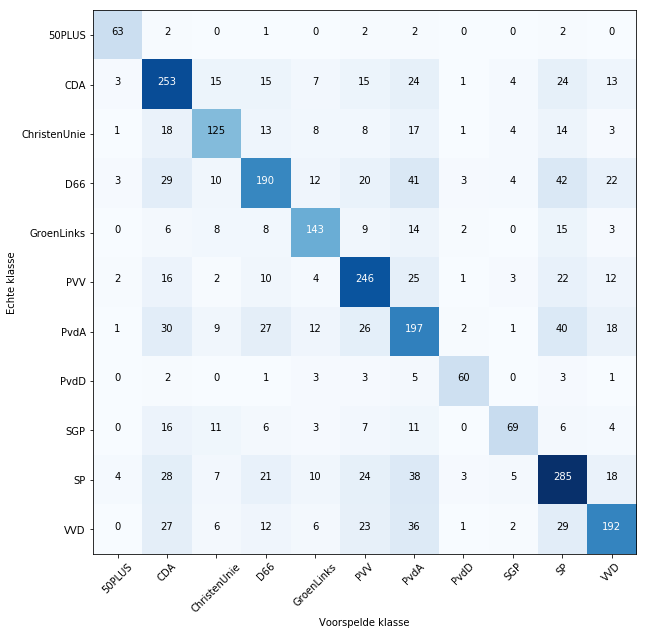

In [25]:
pipe, indiceslist = traintest('Scores.xlsx', df, save = "onlynames", params= {'vect__ngram_range':(1,1),'SGD__max_iter':100}, stemmed='names', normal='names')

In [26]:
mostimportantwords(pipe, countdf, filename='onlynames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,christenunie,d66,groenlinks,pvv,janvos,wassenberg,sgp,jaspervandijk,aukjedevries
1,krol,agnesmulder,dik,piadijkstra,vantongeren,partijvoordevrijheid,albertdevries,partijvoordedieren,vanderstaaij,paulusjansen,vvd
2,timmerman,vanhelvert,faber,koşerkaya,grashoff,tonyvandijck,pvda,ouwehand,houwers,sp,straus
3,smits,geurts,bruins,vanveldhoven,voortman,klever,partijvandearbeid,pvdd,welkzijn,smaling,remcodijkstra
4,klein,ronnes,voordewind,belhaj,klaver,gerbrands,wolbert,thieme,tanamal,bashir,venrooy
5,huizing,bruinsslot,vannieuwenhuizen,vanmeenen,ellemeet,fritsma,jadnanansing,derouwe,vuijk,vangerven,rudmerheerema
6,vanderburg,derouwe,segers,hachchi,vanojik,degraaf,cegerek,recourt,socialistischepartij,leijten,annemulder
7,jansen,keijzer,hilkens,sjoerdsma,smits,agema,marcouch,vanmeenen,hilkens,siderius,welkzijn
8,vanhaersmabuma,omtzigt,schouten,koserkaya,vuijk,madlener,vandekken,vanwijngaarden,dijkgraaf,kooiman,vanveen
9,bruinsslot,vanhaersmabuma,schut,socialistischepartij,pia,deroon,vermue,duindam,verheijen,merkies,deliefde


# Confusion matrix analyse

In [27]:
import networkx as nx
G = nx.Graph()
G.add_edges_from([(8,10), (10,1),(1,5),(5,2),(2,3),(3,0),(0,7),(7,6),(6,4),(4,9)])
F = nx.Graph()
F.add_weighted_edges_from([(8,10,3.971), (10,1,4.928),(1,5,2.059),(5,2,5.439),(2,3,10.981),(3,0,5.533),(0,7,0.154),(7,6,0.093),(6,4,3.026),(4,9,11.342)])

In [28]:
def traintest2(file, data, save=False,params=None,stemmed="stemmed_text",normal="normal_text"):
    train, test = data
    pipe, stem = getbestpipe(file)
    if params!=None:
        pipe.set_params(**params)
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    cm = confusion_matrix(test.party, predicted)
    tot = len(predicted)
    ggg = defaultdict(int)
    ideology = defaultdict(list)
    ideologyw = defaultdict(list)
    mix = []
    regering = []
    oppositie = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                a = (sum(cm[i,:])-cm[i,i]) * (sum(cm[j,:])/(tot-sum(cm[i,:])))
                ggg[(i,sum(cm[i,:]))]+=a
                if i in [6,10] and j in [6,10]:
                    regering.append(cm[i,j]-a)
                elif i in [0,1,2,3,4,5,7,8,9] and j in [0,1,2,3,4,5,7,8,9]:
                    oppositie.append(cm[i,j]-a)
                else:
                    mix.append(cm[i,j]-a)
                ideology[nx.shortest_path_length(G,i,j)].append(cm[i,j]-a)
                ideologyw[nx.dijkstra_path_length(F,i,j)].append(cm[i,j]-a)
    return pipe, oppositie, regering, mix, ggg, ideology,ideologyw

In [29]:
o = []
m = []
r = []
g = {}
ideology2 = []
ideology3 = []
for i in tqdm(range(100)):
    pipe, oppositie, regering, mix, ggg, ideology, ideologyw =traintest2('Scores.xlsx', train_test_split(df, test_size=0.2),params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')
    g ={**g, **ggg}
    o.append(oppositie)
    r.append(regering)
    m.append(mix)
    ideology2.append(ideology)
    ideology3.append(ideologyw)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [6:44:24<00:00, 242.64s/it]


totaal: (0.08797306514280924, 2.3840793726538507e-20)
oppositie: (0.18337576149852478, 1.7574566507822585e-55)
mixed: (-0.2869354213188441, 3.4370630473141225e-69)


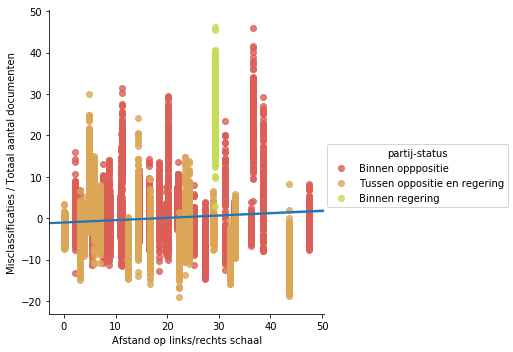

In [79]:
ideology = []
for i in ideology3:
    for j,k in i.items():
        for l in k:
            ideology.append((j,l))

ideology = pd.DataFrame(ideology, columns=['distance','error'])
oppositielist = []
for i in [0,1,2,3,4,5,7,8,9]:
    for j in [0,1,2,3,4,5,7,8,9]:
        oppositielist.append(nx.dijkstra_path_length(F,i,j))
def status(x):
    if x in oppositielist:
        return 'Binnen opppositie'
    elif x==29.187:
        return 'Binnen regering'
    else:
        return 'Tussen oppositie en regering'
ideology['Partij-status'] = ideology.distance.apply(lambda x: status(x))
q= sns.lmplot(x='distance', y='error', hue='Partij-status', data=ideology,fit_reg=False, palette=sns.color_palette("hls", 11))
ax = sns.regplot(ideology.distance, ideology.error, scatter=False, ax=q.axes[0, 0])
ax.set(xlabel = 'Afstand op links/rechts schaal', ylabel = 'Misclassificaties / Totaal aantal documenten')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Ideology.png')
print("totaal:",scipy.stats.pearsonr(ideology.distance,ideology.error))
print("oppositie:",scipy.stats.pearsonr(ideology.loc[ideology['Partij-status'] == 'Binnen opppositie'].distance,ideology.loc[ideology['Partij-status'] == 'Binnen opppositie'].error))
print("mixed:",scipy.stats.pearsonr(ideology.loc[ideology['Partij-status'] == 'Tussen oppositie en regering'].distance,ideology.loc[ideology['Partij-status'] == 'Tussen oppositie en regering'].error))

(0.7676371423711018, 5.403384839483992e-101)

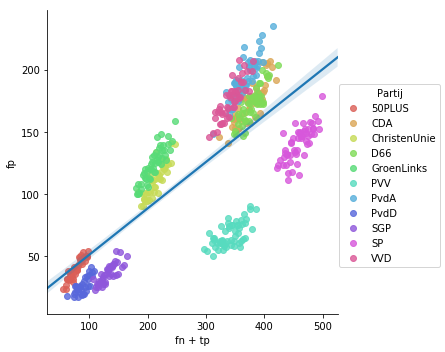

In [31]:
(keys,values) = zip(*g.items())
party, keys = zip(*keys)
keys = pd.Series(keys,name='fn + tp')
values = pd.Series(values,name='fp')
party = pd.Series(party,name="Partij").replace(dict(enumerate(sorted(df.party.unique()))))
q = sns.lmplot(x='fn + tp', y='fp', hue='Partij', data=pd.concat([keys, values, party], axis=1),fit_reg=False, palette=sns.color_palette("hls", 11))
ax = sns.regplot(keys, values, scatter=False, ax=q.axes[0, 0])
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Correlation.png') 
scipy.stats.pearsonr(keys,values)

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean: 0.44152205513362636
NormaltestResult(statistic=3214.2602850646535, pvalue=0.0)


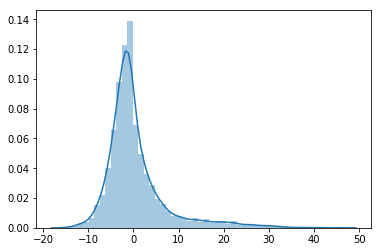

In [32]:
# Dit gebruiken
ax = sns.distplot(list(chain.from_iterable(o)),kde=True)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Oppositie.png') 
print("Mean:",np.mean(list(chain.from_iterable(o))))
print(scipy.stats.normaltest(list(chain.from_iterable((o-np.mean(o))/np.std(o)))))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


NormaltestResult(statistic=0.5488128185864438, pvalue=0.7600231320225153)


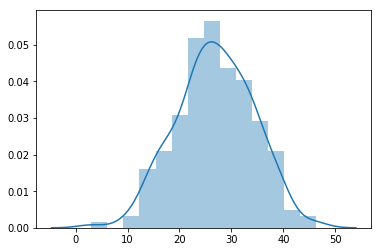

In [33]:
ax = sns.distplot(list(chain.from_iterable(r)),kde=True)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Regering.png') 
np.mean(list(chain.from_iterable(r)))
print(scipy.stats.normaltest(list(chain.from_iterable((r-np.mean(r))/np.std(r)))))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


NormaltestResult(statistic=435.1644146222254, pvalue=3.200722364771719e-95)


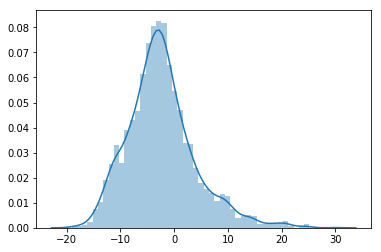

In [34]:
ax = sns.distplot(list(chain.from_iterable(m)),kde=True)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Mix.png') 
np.mean(list(chain.from_iterable(m)))
print(scipy.stats.normaltest(list(chain.from_iterable((m-np.mean(m))/np.std(m)))))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.0
NormaltestResult(statistic=4348.1962183240685, pvalue=0.0)


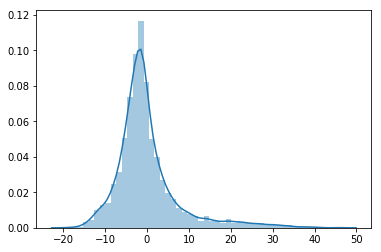

In [35]:
ax = sns.distplot(list(chain.from_iterable(m+o+r)),kde=True)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Totaal.png')
print(np.mean(list(chain.from_iterable(m+o+r))))
print(scipy.stats.normaltest(((list(chain.from_iterable(m+o+r)))-np.mean(list(chain.from_iterable(m+o+r))))/np.std(list(chain.from_iterable(m+o+r)))))

In [36]:
# https://stackoverflow.com/questions/15984221/how-to-perform-two-sample-one-tailed-t-test-with-numpy-scipy
print("R:", scipy.stats.mannwhitneyu(list(chain.from_iterable(r)),list(chain.from_iterable(m)),alternative='greater'))
print("O:", scipy.stats.mannwhitneyu(list(chain.from_iterable(o)),list(chain.from_iterable(m)),alternative='greater'))


R: MannwhitneyuResult(statistic=717042.5, pvalue=7.036729722359468e-124)
O: MannwhitneyuResult(statistic=16328471.0, pvalue=4.438789276419227e-108)


# Woorden Balkenende 4

In [37]:
# Importing data
dfb4 = importdata("HandelingenBalkenende4.csv")
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]

In [38]:
# Creates a dataframe with counts of dataset per party
countdfb4 = pd.concat([dfb4.party.value_counts(),dfb4[dfb4['titel'].str.contains("Vragen van het lid")].party.value_counts(), dfb4[~dfb4['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdfb4.columns = ['Totaal', 'Vragenuur','Debat']
countdfb4 = countdfb4.sort_values("Totaal",axis=0, ascending=False)
countdfb4 = countdfb4.sort_index()
with open("Verslag/Tables/SpreekbeurtenBal.tex", "w") as f:
    f.write(countdfb4.to_latex(header=True))
countdfb4

,Totaal,Vragenuur,Debat
CDA,1039,53,986
ChristenUnie,561,3,558
D66,518,22,496
GroenLinks,760,50,710
PVV,971,56,915
PvdA,903,22,881
PvdD,165,3,162
SGP,507,6,501
SP,1222,70,1152
VVD,1041,55,986


In [39]:
simpleprediction = np.random.choice(countdfb4.index, len(dfb4.party), p = [x/countdfb4["Totaal"].sum() for x in list(countdfb4['Totaal'])])
print(classification_report(dfb4.party, simpleprediction))
print("Accuracy:",accuracy_score(dfb4.party, np.full(len(dfb4.party), countdfb4["Totaal"].idxmax())))

              precision    recall  f1-score   support

         CDA       0.14      0.14      0.14      1039
ChristenUnie       0.06      0.05      0.05       561
         D66       0.06      0.06      0.06       518
  GroenLinks       0.08      0.08      0.08       760
         PVV       0.13      0.14      0.14       971
        PvdA       0.10      0.10      0.10       903
        PvdD       0.02      0.02      0.02       165
         SGP       0.06      0.06      0.06       507
          SP       0.16      0.16      0.16      1222
         VVD       0.15      0.15      0.15      1041

 avg / total       0.11      0.11      0.11      7687

Accuracy: 0.15896968908546896


In [40]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
dfb4['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))
dfb4['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:52<00:00, 106.57s/it]


              Precision  Recall  F1 score  Documenten
CDA                0.46    0.67      0.55         215
ChristenUnie       0.57    0.52      0.54         102
D66                0.70    0.36      0.47         103
GroenLinks         0.59    0.51      0.55         156
PVV                0.67    0.64      0.65         192
PvdA               0.47    0.39      0.42         189
PvdD               0.69    0.39      0.50          34
SGP                0.73    0.80      0.77          97
SP                 0.49    0.64      0.55         239
VVD                0.51    0.40      0.45         211
Totaal             0.56    0.54      0.54        1538
0.5446033810143043


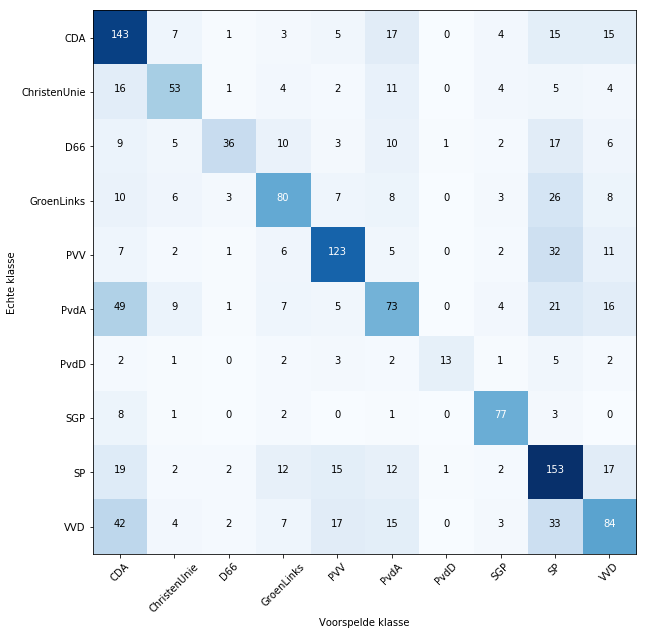

In [41]:
pipe, indiceslist = traintest('Scores.xlsx', dfb4, normal = 'normal_withoutnames', stemmed='stemmed_withoutnames',params= {'SGD__max_iter':100})

In [42]:
mostimportantwords(pipe, countdfb4, 'WoordenBalkenende4')

,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,PARTIJ fractie,fractie van PARTIJ,premier,PARTIJfractie,burgers,wij,dieren,mijn fractie,zegt,PARTIJ
1,wij,de fractie van,de premier,fractie van PARTIJ,onze,vrouwen,natuur,wel,mensen,onze fractie
2,fractie,de fractie,ik hoop,de fractie,niet,belangrijk,bio industrie,beantwoording,problemen,PARTIJ fractie
3,wij hebben,fractie van,arbeidsmarkt,de fractie van,deze,kinderen,de bio industrie,de bewindslieden,niet,fractie
4,KAMERLID,mijn fractie,de arbeidsmarkt,fractie van,immigratie,of,de bio,bewindslieden,vandaar,ondernemers
5,dank,geweest,hoop,politieke,natuurlijk,punt,bio,de voorzitter,is,je
6,PARTIJ fractie heeft,moment,hij,premier,politie,goed,veehouderij,toch,de mensen,want
7,zorgvuldige,termijn,schone energie,deal,de burgers,onderzoek,dierenwelzijn,mijn,bureaucratie,awbz
8,ons,verschillende,plannen,ik,burger,roc,industrie,een,verdrag,eens
9,buitengewoon,beantwoording,kunnen,en,door,vragen,de natuur,natuurlijk,waarom,antwoorden


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [17:25<00:00, 209.07s/it]


              Precision  Recall  F1 score  Documenten
CDA                0.53    0.55      0.54         374
ChristenUnie       0.67    0.47      0.55         221
D66                0.56    0.55      0.56         377
GroenLinks         0.67    0.40      0.51         209
PVV                0.64    0.81      0.72         348
PvdA               0.54    0.49      0.51         370
PvdD               0.77    0.73      0.75          88
SGP                0.77    0.74      0.75         132
SP                 0.56    0.70      0.62         456
VVD                0.55    0.51      0.52         329
Totaal             0.60    0.59      0.58        2903
0.5906303823630727


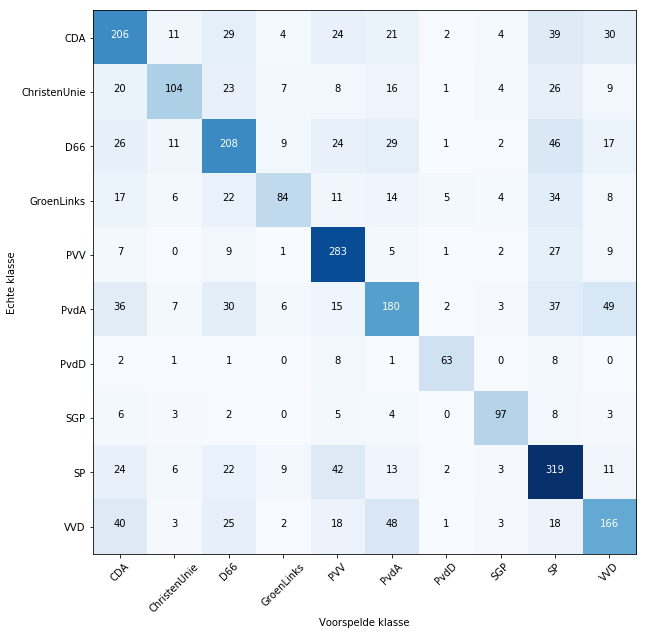

In [43]:
pipe, indiceslist = traintest('Scores.xlsx', df[df.party != '50PLUS'],params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')

In [44]:
# Creates a dataframe with counts of dataset per party
dfz5 = df[df.party != '50PLUS']
countdfz5 = pd.concat([dfz5.party.value_counts(),dfz5[dfz5['titel'].str.contains("Vragen van het lid")].party.value_counts(), dfz5[~dfz5['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdfz5.columns = ['Totaal', 'Vragenuur','Debat']
countdfz5 = countdfz5.sort_values("Totaal",axis=0, ascending=False)
countdfz5 = countdfz5.sort_index()
countdfb4

,Totaal,Vragenuur,Debat
CDA,1039,53,986
ChristenUnie,561,3,558
D66,518,22,496
GroenLinks,760,50,710
PVV,971,56,915
PvdA,903,22,881
PvdD,165,3,162
SGP,507,6,501
SP,1222,70,1152
VVD,1041,55,986


In [45]:
simpleprediction = np.random.choice(countdfz5.index, len(dfz5.party), p = [x/countdfz5["Totaal"].sum() for x in list(countdfz5['Totaal'])])
print(classification_report(dfz5.party, simpleprediction))
print("Accuracy:",accuracy_score(dfz5.party, np.full(len(dfz5.party), countdfz5["Totaal"].idxmax())))

              precision    recall  f1-score   support

         CDA       0.13      0.13      0.13      1901
ChristenUnie       0.08      0.08      0.08      1068
         D66       0.13      0.13      0.13      1889
  GroenLinks       0.08      0.08      0.08      1068
         PVV       0.12      0.12      0.12      1700
        PvdA       0.12      0.12      0.12      1821
        PvdD       0.03      0.03      0.03       432
         SGP       0.04      0.04      0.04       655
          SP       0.16      0.16      0.16      2284
         VVD       0.13      0.13      0.13      1694

 avg / total       0.12      0.12      0.12     14512

Accuracy: 0.15738699007717752


# Vergelijken

In [46]:
def traintest5(file, data, save=False, stemmed="stemmed_text",normal="normal_text",params=None):
    pipe, stem = getbestpipe(file)
    if params!=None:
        pipe.set_params(**params)
    train, test = data
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    print(report)
    print(accuracy_score(test.party, predicted))
    cnf_matrix = confusion_matrix(test.party, predicted)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(train.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())
    return pipe

              Precision  Recall  F1 score  Documenten
CDA                0.28    0.31      0.30        1039
ChristenUnie       0.43    0.19      0.27         561
D66                0.17    0.26      0.20         518
GroenLinks         0.32    0.03      0.06         760
PVV                0.48    0.61      0.54         971
PvdA               0.28    0.29      0.28         903
PvdD               0.64    0.50      0.56         165
SGP                0.54    0.55      0.55         507
SP                 0.41    0.54      0.47        1222
VVD                0.19    0.17      0.18        1041
Totaal             0.35    0.35      0.33        7687
0.3455184077013139


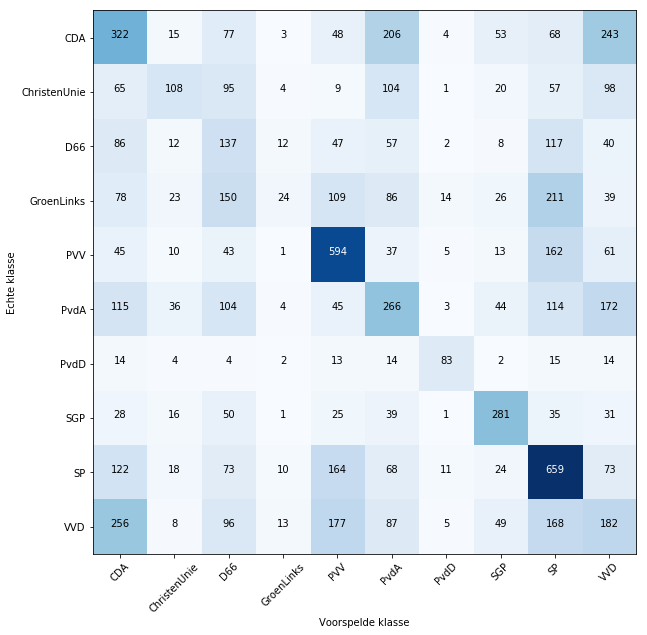

In [47]:
pipe = traintest5('Scores.xlsx', (df[df.party != '50PLUS'],dfb4), save="RutToBal", stemmed="stemmed_withoutnames", normal="normal_withoutnames",params= {'SGD__max_iter':100})

              Precision  Recall  F1 score  Documenten
CDA                0.20    0.41      0.27        1901
ChristenUnie       0.24    0.12      0.16        1068
D66                0.26    0.10      0.14        1889
GroenLinks         0.16    0.07      0.10        1068
PVV                0.50    0.52      0.51        1700
PvdA               0.27    0.25      0.26        1821
PvdD               0.72    0.19      0.30         432
SGP                0.47    0.43      0.45         655
SP                 0.34    0.59      0.44        2284
VVD                0.21    0.10      0.14        1694
Totaal             0.30    0.30      0.28       14512
0.3031284454244763


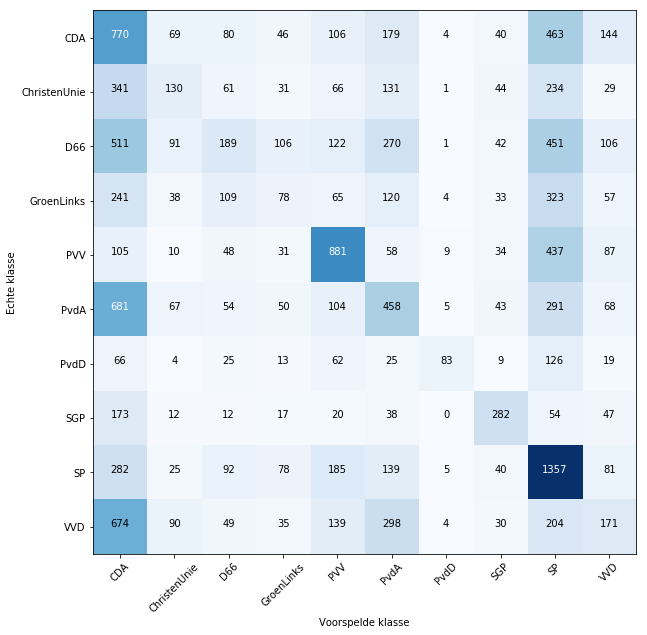

In [48]:
pipe = traintest5('Scores.xlsx', (dfb4,df[df.party != '50PLUS']), save="BalToRut", stemmed="stemmed_withoutnames", normal="normal_withoutnames",params= {'SGD__max_iter':100})

In [49]:
woordenBalk = pd.read_excel('WoordenBalkenende4.xlsx', index_col=0)
woordenRut = pd.read_excel('MostImportantWordsWithoutNames.xlsx', index_col=0)
commondict = defaultdict(dict)
for partyB in ["PvdA", "ChristenUnie", "CDA"]:
    for partyR in ["VVD", "PvdA"]:
        commondict[partyB][partyR] = [x for x in set(woordenBalk[partyB])&set(woordenRut[partyR]) - set(woordenBalk[partyR]) - set(woordenRut[partyB])]
commondict

defaultdict(dict,
            {'CDA': {'PvdA': ['hun', 'toezeggingen', 'collega KAMERLID'],
              'VVD': ['onderwerp',
               'voor PARTIJ',
               'aangegeven',
               'overleg',
               'algemeen overleg',
               'toezegging',
               'beantwoording']},
             'ChristenUnie': {'PvdA': ['over', 'waarop', 'blij', 'erg'],
              'VVD': ['in eerste termijn',
               'blij met de',
               'gaan',
               'volgens',
               'termijn',
               'volgens mij',
               'blij',
               'beantwoording',
               'begroting',
               'uitgebreid',
               'afspraken']},
             'PvdA': {'PvdA': [],
              'VVD': ['we', 'overleg', 'volgens mij', 'afspraken']}})

In [50]:
oppositiewoorden = woordenBalk.drop(["PvdA", "ChristenUnie", "CDA"], axis=1).values.flatten()
pointlesswords = ["in","men","de"]
for partyB in ["PvdA","CDA", "ChristenUnie"]:
    for partyR in ["PvdA", "ChristenUnie", "CDA"]:
        if partyR!=partyB:
            for word in woordenBalk[partyR]:
                for word2 in woordenBalk[partyB]:
                    if word in word2 and word not in pointlesswords and word2 not in pointlesswords and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        #print(partyB, "->",partyR,":",word,",", word2)
                        continue

In [51]:
oppositiewoorden = woordenRut.drop(['VVD', 'PvdA'], axis=1).values.flatten()
for partyB in ["PvdA", "VVD"]:
    for partyR in ["VVD", "PvdA"]:
        if partyR!=partyB:
            for word in woordenRut[partyR]:
                for word2 in woordenRut[partyB]:
                    if word in word2 and word not in ["en","in","men"] and word2 not in ["en","in","men"] and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        print(partyB, "->",partyR,":",word,",", word2)

PvdA -> VVD : we , samenwerking
PvdA -> VVD : we , wel een
PvdA -> VVD : we , welke
PvdA -> VVD : we , vrouwen
PvdA -> VVD : we , werk
PvdA -> VVD : toezegging , toezeggingen
PvdA -> VVD : reden , tevreden
PvdA -> VVD : markt , arbeidsmarkt
PvdA -> VVD : markt , de arbeidsmarkt
PvdA -> VVD : igz , de igz
VVD -> PvdA : beter , verbetercultuur


# Links / Rechts vergelijken

In [52]:
# df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})
# pipe, predicted = traintest('Scores.xlsx', datasplitter(df.dropna(), 0.8))

In [53]:
# pipe, _ = getbestpipe('Scores.xlsx')
# df_train = df.dropna().sample(frac=0.8)
# df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
# df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
# pipe.fit(df_train.withoutnames, df_train.Kieskompas)
# predicted = pipe.predict(df_test.withoutnames)
# print(classification_report(df_test.Kieskompas, predicted))

# Taalgebruik van sprekers

In [54]:
def traintest3(pipe, text, data, save=False):
    trainsprekers, testsprekers = train_test_split(data.surname.unique(), test_size=0.2)
    train = data[data['surname'].isin(trainsprekers)]
    test = data[data['surname'].isin(testsprekers)]
     
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return pipe, cnf_matrix, report, accuracy, indices
    

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 20%|████████████████▌                                                                  | 1/5 [04:17<17:08, 257.18s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 40%|█████████████████████████████████▏                                                 | 2/5 [08:48<13:12, 264.19s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: Undef

              Precision  Recall  F1 score  Documenten
50PLUS             0.48    0.15      0.16          93
CDA                0.13    0.15      0.12         351
ChristenUnie       0.13    0.07      0.09         239
D66                0.19    0.27      0.18         309
GroenLinks         0.09    0.02      0.03         188
PVV                0.42    0.48      0.44         455
PvdA               0.20    0.25      0.21         304
PvdD               0.33    0.23      0.17          95
SGP                0.30    0.07      0.11         133
SP                 0.26    0.31      0.28         560
VVD                0.31    0.23      0.26         382
Totaal             0.31    0.23      0.23        3110
0.23443333664094287


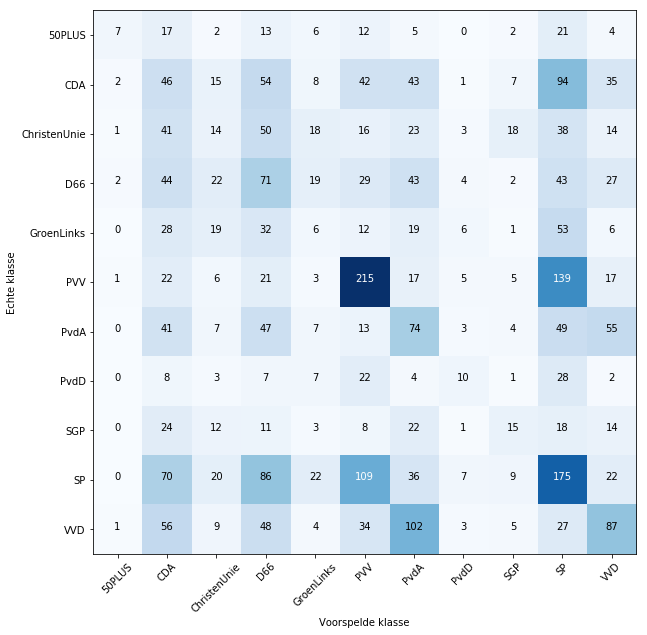

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50 plussers,inwoners,zullen,mijn fractie,kamer hierover te,islamitische,en,natuur,mevrouw de voorzitter,zegt,PARTIJ
1,50,PARTIJ fractie,gezinnen,mijn,persoonsgebonden,natuurlijk,die,dieren,mevrouw de,thuiszorg,PARTIJ fractie
2,gepensioneerden,regering,elkaar,buitengewoon,beraadslaging overwegende dat,nederland,circulaire economie,milieu,wel,bezuinigingen,aruba
3,plussers,PARTIJ,mensenhandel,natuurlijk,schone energie,islam,circulaire,bio,bewindslieden,mensen,regelgeving
4,50 plusser,de regering,hoop,fractie,regering om,de islam,collega,bio industrie,mevrouw,personeel,partijen
5,de gepensioneerden,de,inderdaad,minister,schone,al,daarbij,de bio,de voorzitter ik,niet,speelveld
6,de 50,echt,vluchtelingen,het kabinet,de regering om,asielzoekers,wij,industrie,is,mening dat,aangegeven
7,plusser,rekentoets,de eurozone,belangrijk,de beraadslaging overwegende,PARTIJ,mijn partij,burgers,naar voren,van mening dat,banen
8,wij,wij,ik,vandaag,beraadslaging overwegende,dit kabinet,stap,de bio industrie,voor de beantwoording,toch,en
9,oudere,zouden,eurozone,vind,hierover te informeren,grenzen,tevens,constaterende dat,de voorzitter,armoede,volgens mij


In [55]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="taalgebruik", stemmed='stemmed_withoutnames', normal='normal_withoutnames',params= {'SGD__max_iter':100})
mostimportantwords(pipe, countdf, 'taalgebruik')